In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
import random

In [ ]:
!unzip "/content/drive/MyDrive/Crack/crack_segmentation_dataset/crack_segmentation_dataset.zip" -d "/content/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dir = "/content/crack_segmentation_dataset/train/images/"
target_dir = "/content/crack_segmentation_dataset/train/masks/"
img_size = (448,448)
num_classes = 2
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 9603
/content/crack_segmentation_dataset/train/images/CFD_002.jpg | /content/crack_segmentation_dataset/train/masks/CFD_002.jpg
/content/crack_segmentation_dataset/train/images/CFD_003.jpg | /content/crack_segmentation_dataset/train/masks/CFD_003.jpg
/content/crack_segmentation_dataset/train/images/CFD_004.jpg | /content/crack_segmentation_dataset/train/masks/CFD_004.jpg
/content/crack_segmentation_dataset/train/images/CFD_005.jpg | /content/crack_segmentation_dataset/train/masks/CFD_005.jpg
/content/crack_segmentation_dataset/train/images/CFD_006.jpg | /content/crack_segmentation_dataset/train/masks/CFD_006.jpg
/content/crack_segmentation_dataset/train/images/CFD_008.jpg | /content/crack_segmentation_dataset/train/masks/CFD_008.jpg
/content/crack_segmentation_dataset/train/images/CFD_009.jpg | /content/crack_segmentation_dataset/train/masks/CFD_009.jpg
/content/crack_segmentation_dataset/train/images/CFD_010.jpg | /content/crack_segmentation_dataset/train/masks/CFD_

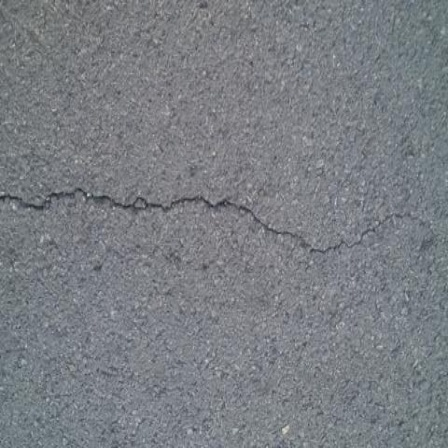

224 33
(448, 448, 3)
1 0


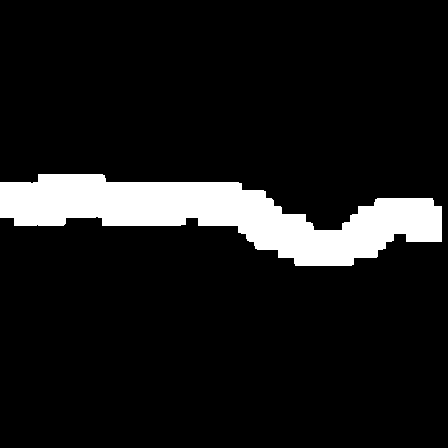

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import cv2
# Display input image #7
temp = 20
display(Image(filename=input_img_paths[temp]))
img = cv2.imread(input_img_paths[temp])
print(np.max(img), np.min(img))
# Display auto-contrast version of corresponding target (per-pixel categories)
img = cv2.imread(target_img_paths[temp])
img[img>0] = 1
print(img.shape)

print(np.max(img), np.min(img))
kernel = np.ones((5,5), np.uint8)
img = cv2.dilate(img, kernel, iterations=5)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(img))
# img = PIL.ImageOps.autocontrast(Image(img))
# img[img==255] = 1
# print(load_img(target_img_paths[100]))
display(img)


In [ ]:
class CracksAnn(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        # print('yshape:',y.shape)
        for j, path in enumerate(batch_target_img_paths):
            img = np.array(load_img(path, target_size=self.img_size, color_mode="grayscale"))
            # img = np.interp(img, (np.min(img), np.max(img)), (1, 3)).astype(int)
            img[img>0] = 1
            kernel = np.ones((5,5), np.uint8)
            img = cv2.dilate(img, kernel, iterations=5)
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
        # print('yshape:',y.shape)
        return x, y

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    # x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
val_samples = 500
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = CracksAnn(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = CracksAnn(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer=keras.optimizers.Adam(2e-5), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# callbacks = [
#     keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab/Project/Crack segementation/segmentation.h5", save_best_only=True)
# ]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/10
284/284 [==============================] - 491s 2s/step - loss: 0.1741 - accuracy: 0.9122 - val_loss: 0.2005 - val_accuracy: 0.8695
Epoch 2/10
284/284 [==============================] - 488s 2s/step - loss: 0.1690 - accuracy: 0.9114 - val_loss: 0.1648 - val_accuracy: 0.8998
Epoch 3/10
284/284 [==============================] - 488s 2s/step - loss: 0.1643 - accuracy: 0.9106 - val_loss: 0.1673 - val_accuracy: 0.9151
Epoch 4/10
284/284 [==============================] - 490s 2s/step - loss: 0.1597 - accuracy: 0.9095 - val_loss: 0.1596 - val_accuracy: 0.9147
Epoch 5/10
284/284 [==============================] - 490s 2s/step - loss: 0.1561 - accuracy: 0.9088 - val_loss: 0.1567 - val_accuracy: 0.9159
Epoch 6/10
284/284 [==============================] - 489s 2s/step - loss: 0.1522 - accuracy: 0.9078 - val_loss: 0.1480 - val_accuracy: 0.9139
Epoch 7/10
284/284 [==============================] - 489s 2s/step - loss: 0.1489 - accuracy: 0.9075 - val_loss: 0.1484 - val_accuracy: 0.9111

In [ ]:
model.save("/content/drive/MyDrive/trained_model_newData_30epochs.h5")

In [ ]:
test_img = load_img("/content/drive/MyDrive/Colab/train/cracked/11.jpg")
pred = model.predict(test_img)

In [ ]:
val_gen_new = CracksAnn(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)
print("val : ", val_preds.shape[0])


def display_mask(i):
    """Quick utility to display a model's prediction."""
    print("val : ", val_preds[i].shape)
    # print(val_preds[i])
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    print("mask : ", mask.shape)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
    # img = np.array(img)
    # print(img.shape)

val :  480


(448, 448, 3) (448, 448)
(448, 448, 3) (448, 448, 3)


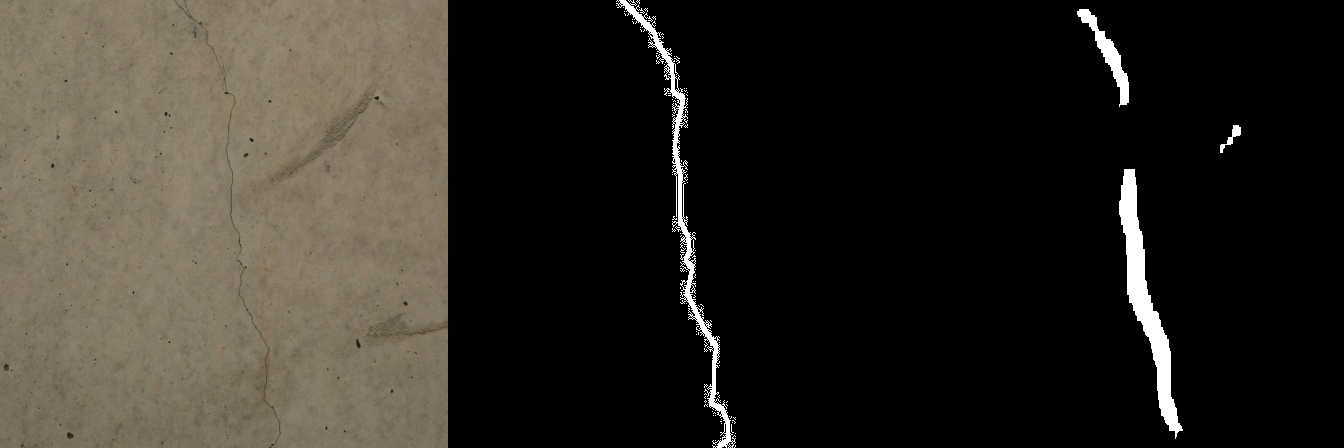

In [ ]:
i = 15
og_img = cv2.imread(val_input_img_paths[i])
# display(Image(filename=val_input_img_paths[i]))
exp_mask = cv2.imread(val_target_img_paths[i])
mask = np.argmax(val_preds[i], axis=-1)
mask[mask==1] = 255
mask = np.array(mask, dtype = np.uint8)

kernel = np.ones((5,5), np.uint8)
mask = cv2.erode(mask, kernel, iterations = 4)

print(exp_mask.shape, mask.shape)
mask = np.stack((mask,)*3, axis=-1)
print(exp_mask.shape, mask.shape)

# mask = np.expand_dims(mask, axis=-1)
# print(mask.shape, exp_mask.shape)
# print(exp_mask)
view_mode = np.concatenate((og_img, exp_mask, mask), axis = 1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(view_mode))
display(img)

In [ ]:
for i in range(val_preds.shape[0]):
  # display(Image(filename=val_input_img_paths[i]))
  og_img = cv2.imread(val_input_img_paths[i])
  exp_mask = cv2.imread(val_target_img_paths[i])

  mask = np.argmax(val_preds[i], axis=-1)
  mask[mask==1] = 255
  mask = np.array(mask, dtype = np.uint8)
  kernel = np.ones((5,5), np.uint8)
  mask = cv2.erode(mask, kernel, iterations = 4)
  mask = np.stack((mask,)*3, axis=-1)
  
  view_mode = np.concatenate((og_img, exp_mask, mask), axis = 1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(view_mode))
  # cv2.imwrite("/content/drive/MyDrive/Crack/crack_segmentation_dataset/Output_validationSet/%s.png"%i, view_mode)
  

In [ ]:
cfd_input_dir = "/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/"
cfd_target_dir = "/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/"

cfd_input_img_paths = sorted(
    [
        os.path.join(cfd_input_dir, fname)
        for fname in os.listdir(cfd_input_dir)
        if fname.endswith(".jpg")
    ]
)
cfd_target_img_paths = sorted(
    [
        os.path.join(cfd_target_dir, fname)
        for fname in os.listdir(cfd_target_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(cfd_input_img_paths))

for input_path, target_path in zip(cfd_input_img_paths[:10], cfd_target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 118
/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/001.jpg | /content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/001.png
/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/002.jpg | /content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/002.png
/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/003.jpg | /content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/003.png
/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/004.jpg | /content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/004.png
/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/005.jpg | /content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/005.png
/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image/006.jpg | /content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/seg_gt/006.png
/content/drive/MyDrive/Crack/cfd_image.zip (Unz

In [ ]:
kernel = np.ones((5,5), np.uint8)
for j in range(len(cfd_input_img_paths)):
  cfd_img = np.expand_dims(cv2.imread(cfd_input_img_paths[j]), axis = 0)
  cfd_img_pred = model.predict(cfd_img)[0]
  cfd_img_pred = np.array(np.argmax(cfd_img_pred, axis=-1), dtype = np.uint8)
  cfd_img_pred = cv2.erode(cfd_img_pred, kernel, iterations = 4)
  cfd_img_pred = np.expand_dims(cfd_img_pred, axis = -1)
  cfd_img_pred[cfd_img_pred==1] = 255
  name = j+1
  cv2.imwrite("/content/drive/MyDrive/Crack/cfd_image.zip (Unzipped Files)/cfd_image_predictions/%s.png"%name, cfd_img_pred)
print(cfd_img_pred.shape)

(320, 480, 1)


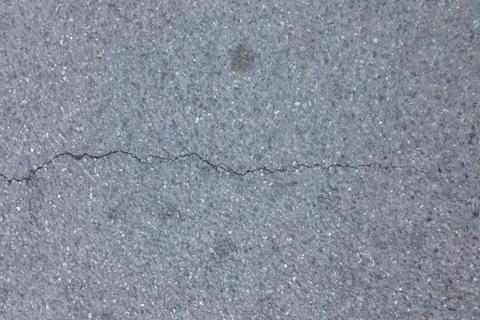

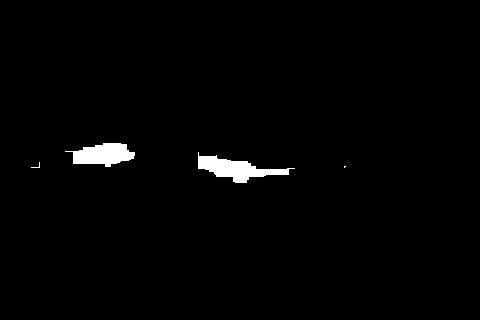

In [ ]:
display(Image(filename=cfd_input_img_paths[j]))
pred = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(cfd_img_pred))
display(pred)